In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
#import as F
import torch.nn.functional as F


tensor([219.3926,   4.3155,  60.1124,   6.3994,   3.9836,   8.3891,   4.3155,
        121.5132, 101.4277,  15.7781])
tensor([0.4021, 0.0079, 0.1102, 0.0117, 0.0073, 0.0154, 0.0079, 0.2227, 0.1859,
        0.0289])


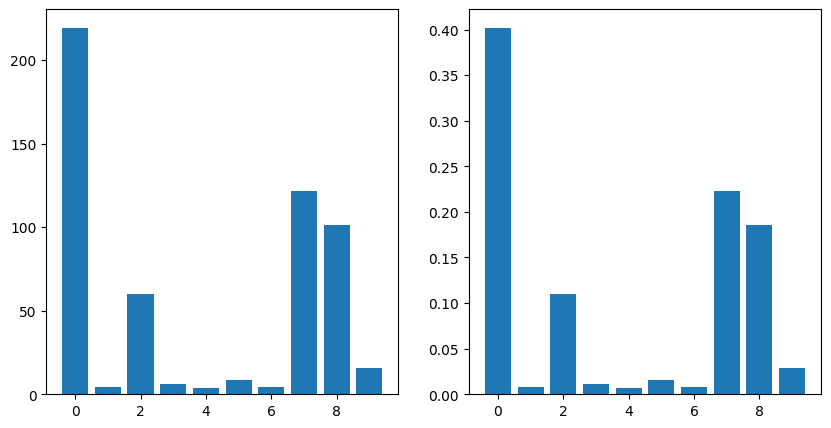

In [4]:
#For 10 classes, then N_c has the number of samples for each class in a torch tensor
N = torch.tensor([4,3,8,4,2,1,3,6,5,2])
beta_prior = 1 # will be unform dirichlet if ood datapoint
# the log probs will be the flow density estimations of a data point for each class
# lets say the datapoint should actually be from class 1, then the log_probs will be the flow density estimations for class 1
# so ideally we want a high prob for class 1 and lower probs for the other classes
log_probs = torch.tensor([4, 0.1, 2, 0.3, 0.4, 2, 0.1, 3, 3, 2])
alphas = torch.zeros(10)
for c in range(10):
        alphas[c] = beta_prior + N[c] * torch.exp(log_probs[c])
print(alphas)
# normalise the alphas
alphas_norm = F.normalize(alphas, p=1, dim=0)
print(alphas_norm)
#preds = torch.max(alphas_norm, dim=-1)[0] # if using batches
#print(preds)
#plot the alphas and the normalised alphas in a bar plot side by side
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].bar(range(10), alphas)
ax[1].bar(range(10), alphas_norm)
#ax[2].bar(range(10), preds)
plt.show()

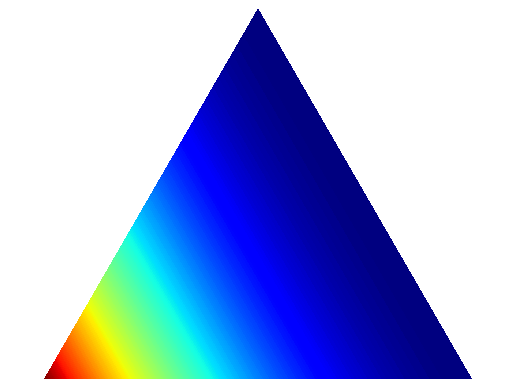

In [5]:
#https://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

# plt.figure(figsize=(8, 4))
# for (i, mesh) in enumerate((triangle, trimesh)):
#     plt.subplot(1, 2, i+ 1)
#     plt.triplot(mesh)
#     plt.axis('off')
#     plt.axis('equal')

# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])
    
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

draw_pdf_contours(Dirichlet([3,1,1]))

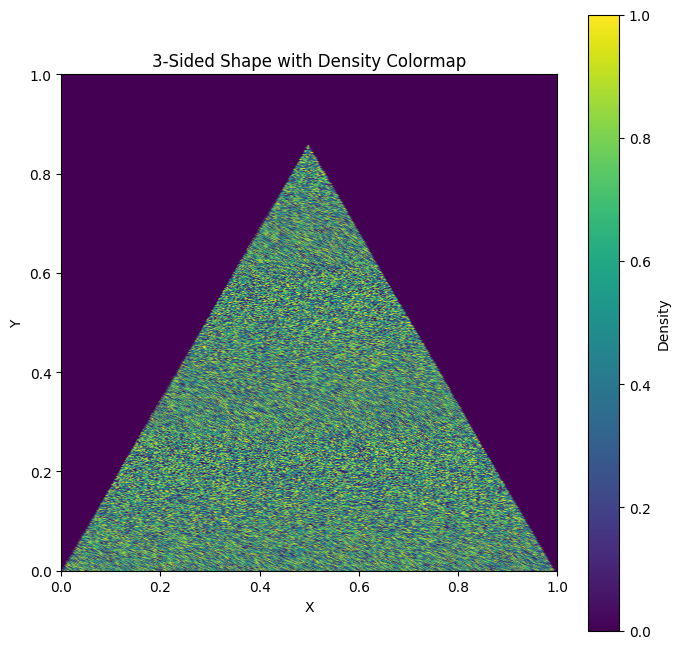

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize

# Define the vertices of a regular 3-sided polygon (equilateral triangle)
vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Create a polygon patch for the 3-sided shape
polygon = Polygon(vertices, closed=True, edgecolor='k', lw=2, fill=False)
ax.add_patch(polygon)

# Create a grid of points within the triangle
x, y = np.meshgrid(np.linspace(0, 1, 500), np.linspace(0, 1, 500))
points = np.column_stack((x.flatten(), y.flatten()))

# Filter points that are inside the triangle using a point-in-polygon check
path = Polygon(vertices).get_path()
mask = path.contains_points(points).reshape(x.shape)

# Create random densities for the points inside the triangle
densities = np.random.rand(*x.shape) * mask

# Create a colormap and normalize the densities
cmap = plt.get_cmap('viridis')
norm = Normalize(vmin=0, vmax=1)

# Create a scatter plot with colors based on densities
scatter = ax.scatter(x, y, c=densities, cmap=cmap, norm=norm, s=20)

# Add a colorbar
cbar = fig.colorbar(scatter, ax=ax, label='Density')

# Set axis limits and labels
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Set aspect ratio to equal
ax.set_aspect('equal')

# Add a title
ax.set_title('3-Sided Shape with Density Colormap')

# Show the plot
plt.show()

ValueError: operands could not be broadcast together with shapes (3,1) (500,500) 

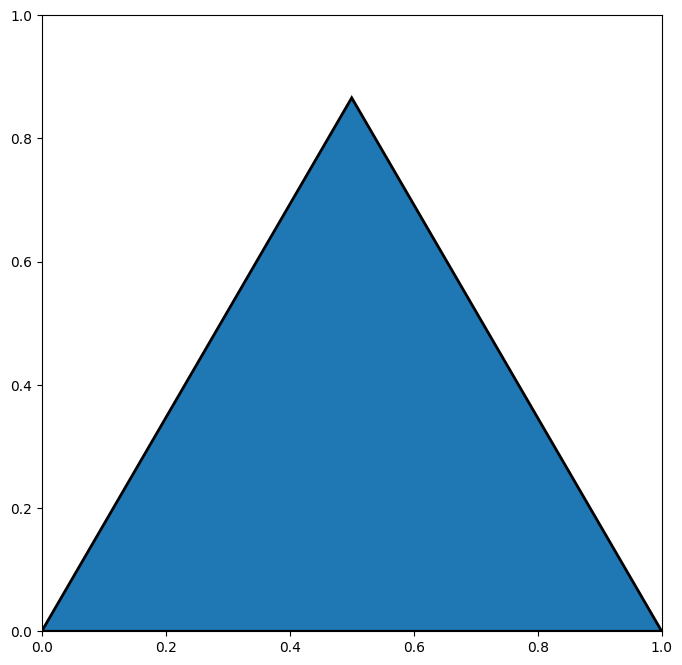

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize

# Define the vertices of a regular 3-sided polygon (equilateral triangle)
vertices = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2]])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Create a polygon patch for the 3-sided shape and fill it with a colormap
polygon = Polygon(vertices, closed=True, edgecolor='k', lw=2)
ax.add_patch(polygon)

# Create a grid of points within the triangle
x, y = np.meshgrid(np.linspace(0, 1, 500), np.linspace(0, 1, 500))
points = np.column_stack((x.flatten(), y.flatten()))

# Filter points that are inside the triangle using a point-in-polygon check
path = Polygon(vertices).get_path()
mask = path.contains_points(points).reshape(x.shape)

# Replace this line with your alphas normalized to the range [0, 1]
alphas = torch.tensor([0.8, 0.1, 0.1])  # Replace with your alphas
densities = (alphas[:, None] - alphas.min()) / (alphas.max() - alphas.min()) * mask

# Set the colormap for the filled triangle based on densities
polygon.set_facecolor(plt.cm.viridis(densities))

# Add a colorbar
norm = Normalize(vmin=densities.min(), vmax=densities.max())
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])  # An empty array is needed for cmap to work with ScalarMappable
cbar = fig.colorbar(sm, ax=ax, label='Density')

# Set axis limits and labels
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Set aspect ratio to equal
ax.set_aspect('equal')

# Add a title
ax.set_title('3-Sided Shape with Filled Colormap based on Alphas')

# Show the plot
plt.show()

